In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Yolo/BCCD/BCCD.zip

In [ ]:
import os, shutil 
os.rename('/content/BCCD_Dataset-master', '/content/BCCD_Dataset')

In [ ]:
# Create a dataset
os.mkdir('/content/Dataset/')

--

Import packages

In [ ]:
# Linear Algebra
import numpy as np

# File Handling
import os
import shutil
import xml.etree.ElementTree as ET
   
# Free memory
import gc

# Image processing libraries
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Variables
str_Input_folder_Path = '/content/BCCD_Dataset/'
str_Files_Split_Info_Path = str_Input_folder_Path + 'BCCD/ImageSets/Main/'
str_Images_Path =  str_Input_folder_Path + 'BCCD/JPEGImages/'
str_Annotations_Path = str_Input_folder_Path + 'BCCD/Annotations/'
str_Yolo_Annotations_Path = str_Input_folder_Path + 'AnnotLabels/'

# Base Location for our Image and Annotation files
str_Destination_Path = '/content/Dataset/'
str_Destination_Images_Path = str_Destination_Path + 'images/'
str_Destination_Labels_Path = str_Destination_Path + 'labels/'

classes = [ 'RBC', 'WBC', 'Platelets']

--

Create folder structure required by Yolo5

In [ ]:
# Check if directory exists and if not, create it and the child directories
if not(os.path.isdir(str_Destination_Images_Path)):
    os.mkdir(str_Destination_Images_Path)    
    # Child directories
    os.mkdir(str_Destination_Images_Path + '/train')
    os.mkdir(str_Destination_Images_Path + '/val')
    os.mkdir(str_Destination_Images_Path + '/test')
        
# Check if directory exists and if not, create it and the child directories
if not(os.path.isdir(str_Destination_Labels_Path)):
    os.mkdir(str_Destination_Labels_Path)    
    # Child directories
    os.mkdir(str_Destination_Labels_Path + '/train')
    os.mkdir(str_Destination_Labels_Path + '/val') 
    os.mkdir(str_Destination_Labels_Path + '/test')

--

Create Annotation file in the format Yolo5 requires

In [ ]:
def yolo_format(width, height, box):

    # x1 = 'x' upper-left; y1 = 'y' upper-left; x2 = 'x' lower-right; y2 = 'y' lower-right; 
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    # Need to normalize values
    dw = np.float32(1. / int(width))
    dh = np.float32(1. / int(height))

    # Get the center coordinates
    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    # Normalize data
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return x, y, w, h

In [ ]:
# Convert Annotations from VOC to Yolo5 format and save the files
def create_annotations(InputFile, DestPath):
  str_File_Contents = ET.parse(InputFile)

  # Check if directory exists and if not, create it and the child directories
  if not(os.path.isdir(DestPath)):
    os.mkdir(DestPath)  

  # Get the root element
  root = str_File_Contents.getroot()
  
  # Element 1 is Filename and we want the filename without the extension as we will add one
  str_File_Name = root[1].text[:-4]+ ".txt"  

  # Element 4 is size and it has Width and Depth
  str_Img_width = root[4][0].text            
  str_Img_Height = root[4][1].text

  # Loop through all 'Object' element. This has inputs on classes and bouding box co-ordinates
  lstAnnot = []
  for info in root.findall('object'):
    img_class = info[0].text
    x1 = info[4][0].text
    y1 = info[4][1].text
    x2 = info[4][2].text
    y2 = info[4][3].text
    lstAnnot.append([img_class, x1, y1, x2, y2])

  # Save the annotation text file
  str_Dest_Path = DestPath + str_File_Name
  strFile = open(str_Dest_Path, "a+")
  for box in lstAnnot:
    cls = classes.index(box[0])
    x,y,w,h = yolo_format(str_Img_width, str_Img_Height, box[1:])
    strFile.write(f"{cls} {x} {y} {w} {h}\n")

  strFile.flush()
  strFile.close() 

In [ ]:
for annotfile in os.listdir(str_Annotations_Path):
  create_annotations(str_Annotations_Path + annotfile,str_Yolo_Annotations_Path)

In [ ]:
# Check if we have processed all annotation files in source folder and in the destination folder
len(os.listdir(str_Annotations_Path)) == len(os.listdir(str_Yolo_Annotations_Path))

True

--

Move the 'Train', 'Valid' and 'Test' images and annotations, to respectieg folders

In [ ]:
# Use the 'splits' and move respective image and annotations to right folder
for fil in os.listdir(str_Files_Split_Info_Path):
  if 'trainval' in fil:
    pass
    
  elif 'train' in fil:
    print('Working on the train file: ', str_Files_Split_Info_Path + fil)
    with open(str_Files_Split_Info_Path + fil, 'r') as input_file:
      for current_file in input_file:
        shutil.copy(str_Images_Path + current_file.strip() + '.jpg', str_Destination_Images_Path + 'train/' )
        shutil.copy(str_Yolo_Annotations_Path + current_file.strip()  + '.txt', str_Destination_Labels_Path + 'train/' )

  elif 'val' in fil:
    print('Working on the validation file: ', str_Files_Split_Info_Path + fil)
    with open(str_Files_Split_Info_Path + fil, 'r') as input_file:
      for current_file in input_file:
        shutil.copy(str_Images_Path + current_file.strip() + '.jpg', str_Destination_Images_Path + 'val/' )
        shutil.copy(str_Yolo_Annotations_Path + current_file.strip() + '.txt', str_Destination_Labels_Path + 'val/' )

  elif 'test' in fil:
    print('Working on the test file: ', str_Files_Split_Info_Path + fil)
    with open(str_Files_Split_Info_Path + fil, 'r') as input_file:
      for current_file in input_file:
        shutil.copy(str_Images_Path + current_file.strip() + '.jpg', str_Destination_Images_Path + 'test/' )
        shutil.copy(str_Yolo_Annotations_Path + current_file.strip() + '.txt', str_Destination_Labels_Path + 'test/' )


Working on the test file:  /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt
Working on the validation file:  /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt
Working on the train file:  /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt


In [ ]:
# Print records count
print('Total Training Images: {0}'.format(len(os.listdir(str_Destination_Images_Path + 'train/'))))
print('Total Validation Images: {0}'.format(len(os.listdir(str_Destination_Images_Path + 'val/'))))
print('Total Test Images: {0}'.format(len(os.listdir(str_Destination_Images_Path + 'test/'))))

Total Training Images: 205
Total Validation Images: 87
Total Test Images: 72


In [ ]:
# Check file count in source and destination (ie: in 'train', 'valid' and 'test' folders)
print(len(os.listdir(str_Destination_Images_Path + 'train/')) == len(os.listdir(str_Destination_Labels_Path + 'train/')))
print(len(os.listdir(str_Destination_Images_Path + 'val/')) == len(os.listdir(str_Destination_Labels_Path + 'val/' )))
print(len(os.listdir(str_Destination_Images_Path + 'test/')) == len(os.listdir(str_Destination_Labels_Path + 'test/' )))

True
True
True


--

View Sample file

In [ ]:
# Read a sample annotation file. Contents are:  'Class','x','y','W','H '
with open ('/content/Dataset/labels/train/BloodImage_00001.txt','r') as annot:
    for content in annot:
      print(content.rstrip())

1 0.2765625041211024 0.8281250431900844 0.34062500507570803 0.34375001792795956
0 0.6187500092200935 0.8489583776099607 0.15625000232830644 0.19375001010484993
0 0.1554687523166649 0.49791669263504446 0.14531250216532499 0.25000001303851604
0 0.7695312614669092 0.9166667144745588 0.1359375020256266 0.1666666753590107
0 0.788281261746306 0.358333352021873 0.1359375020256266 0.1666666753590107
0 0.7773437615833245 0.6979167030658573 0.1359375020256266 0.1666666753590107
0 0.7226562607684173 0.693750036181882 0.14218750211875886 0.20833334419876337
0 0.5054687575320713 0.8260417097480968 0.14218750211875886 0.22708334517665207
0 0.9226562637486495 0.23020834533963352 0.14218750211875886 0.20208334387280047
0 0.8289062623516656 0.2906250151572749 0.14218750211875886 0.20208334387280047
0 0.6359375094762072 0.44166668970137835 0.09687500144354999 0.17083334224298596
0 0.5656250084284693 0.46666669100522995 0.10312500153668225 0.19583334354683757
0 0.5453125081257895 0.23645834566559643 0.18

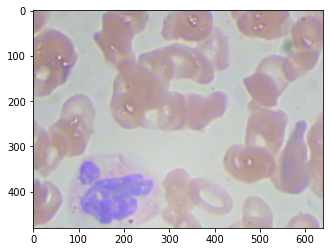

In [ ]:
# View a sample image
img = Image.open('/content/Dataset/images/train/BloodImage_00001.jpg')
plt.imshow(img)

In [ ]:
# Sample .yaml file for Yolo. Format is:

# train: path to train folder containing images
# val: path to val folder containing images
# nc: the number of classes
# names: the names of the classes

In [ ]:
os.getcwd()

'/content'

In [ ]:
# Create the .yaml file required for Yolo
# Since we would be inside Yolo directory, we use '..' to move to parent directory and then into sub directories for images and labels
with open(str_Destination_Path + 'dataset.yaml', 'w') as fil:
    fil.write("train: " + "../Dataset/images/train/\n")
    fil.write("val: " + "../Dataset/images/val/\n")
    fil.write("\n")
    fil.write("nc: 3\n")
    fil.write("\n")
    fil.write("names: ['RBC', 'WBC', 'Platelets']")    

In [ ]:
# Install Yolo 5 and dependencies
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9008, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 9008 (delta 21), reused 28 (delta 14), pack-reused 8963
Receiving objects: 100% (9008/9008), 9.46 MiB | 22.26 MiB/s, done.
Resolving deltas: 100% (6266/6266), done.


In [ ]:
# Change current directory to Yolo5
%cd '/content/yolov5'

/content/yolov5


In [ ]:
# Install necessary files
! pip install -r requirements.txt

In [ ]:
# Move the .yaml file to yolo folder
shutil.move(str_Destination_Path + 'dataset.yaml', '/content/yolov5' )

'/content/yolov5/dataset.yaml'

In [ ]:
# Weights from https://github.com/ultralytics/yolov5/releasess
shutil.copy('/content/gdrive/MyDrive/yolov5s.pt', '/content/yolov5/yolov5s.pt')

'/content/yolov5/yolov5s.pt'

In [ ]:
gc.collect()

272

--

Train Yolo

In [ ]:
!python train.py --img 640  --batch 8 --epochs 50 --data dataset.yaml --weights yolov5s.pt  --cache   

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=200, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, pers

In [ ]:
gc.collect()                                                      

100

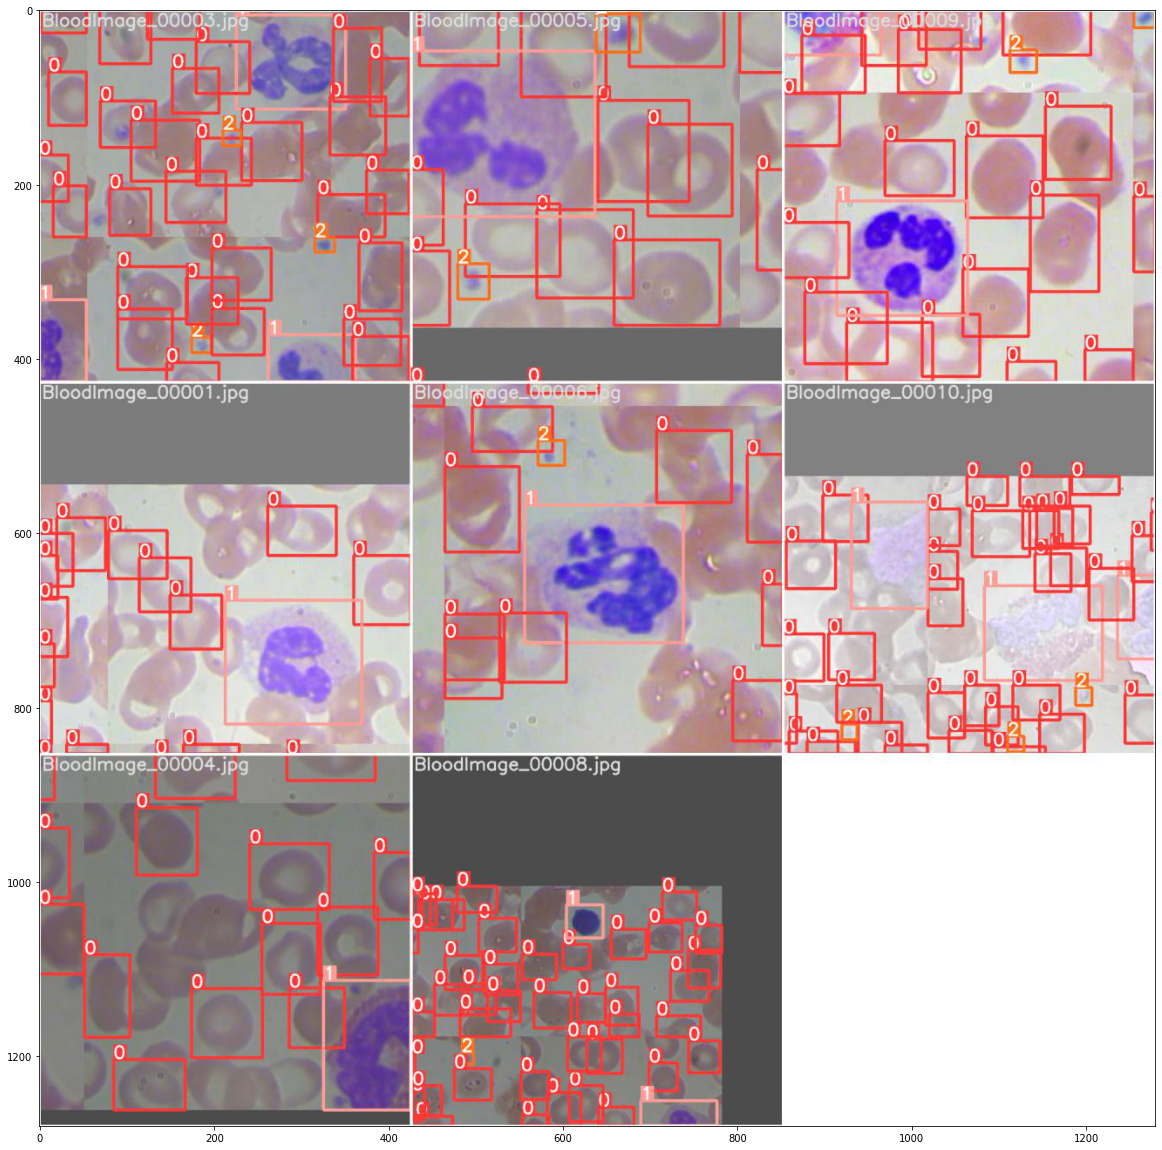

In [ ]:
img = Image.open('/content/yolov5/runs/train/exp/train_batch0.jpg')
plt.figure(figsize=(20,35))
plt.imshow(img)

--

In [ ]:
gc.collect()

50

Inference using trained Yolo model

In [ ]:
!python detect.py --source

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--imgsz IMGSZ [IMGSZ ...]] [--conf-thres CONF_THRES]
                 [--iou-thres IOU_THRES] [--max-det MAX_DET] [--device DEVICE]
                 [--view-img] [--save-txt] [--save-conf] [--save-crop]
                 [--nosave] [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--tfl-int8]
detect.py: error: argument --source: expected one argument


In [ ]:
!python detect.py --source  '/content/Dataset/images/test'  --weights "/content/yolov5/runs/train/exp/weights/best.pt"   --conf-thres 0.4

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/Dataset/images/test, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, tfl_int8=False
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/72 /content/Dataset/images/test/BloodImage_00007.jpg: 480x640 11 RBCs, 1 WBC, 1 Platelets, Done. (0.028s)
image 2/72 /content/Dataset/images/test/BloodImage_00011.jpg: 480x640 14 RBCs, 1 WBC, 1 Platelets, Done. (0.027s)
image 3/72 /content/Dataset/images/test/BloodImage_00015.jpg: 480x640 14 RBCs, 1 WBC, 2 Plateletss, Done. (0.028s)
image 4/72 /content/Da

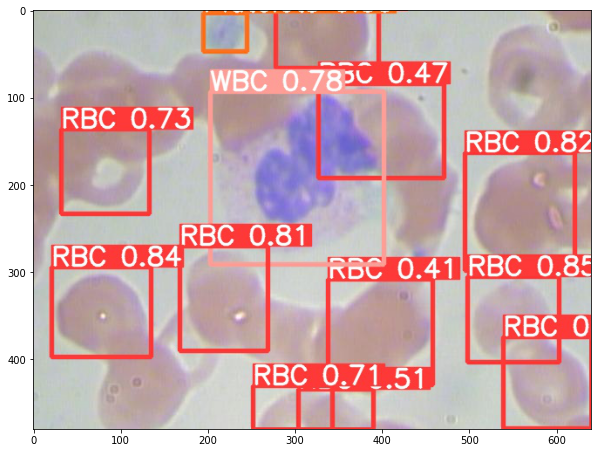

In [ ]:
img = Image.open('/content/yolov5/runs/detect/exp/BloodImage_00007.jpg')
plt.figure(figsize=(10,10))
plt.imshow(img)
# we can see one 'WBC' and several 'RBC' classes

In [ ]:
gc.collect()

152